In [1]:
import numpy as np
import os
import random
import pydicom
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology, draw 
import re
from PIL import Image

In [3]:
#### Haven't done this yet!!!

from sklearn.model_selection import train_test_split

#### DO IT!!!

In [229]:
number = 5.4343629
arr = [3,4,5,6]
formatted_number = f"{(100*number):.2f}"
print(arr)

[3, 4, 5, 6]


In [5]:
def load_dicom_file(filepath):
    """Loads a given DICOM file given the file path."""
    try:
        ds = pydicom.dcmread(filepath)
        return ds
    except pydicom.errors.InvalidDicomError:
        print(f"Error: '{filepath}' is not a valid DICOM file.")
        print("It might be a true Unix executable or a corrupted file.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [7]:
def load_binary_mask(filepath):
    """Returns a 2D binary NumPy array mask given the file path."""
    try:
        # load the mask file
        img = Image.open(filepath)

        # convert to greyscale, and store as 2D NumPy array
        mask = np.array(img.convert('L'))
    
        # binarize mask 
        mask[mask <=2] = 1
        mask[mask > 2] = 0
        
        return mask
    except FileNotFoundError:
        print(f"Error: '{filepath[(filepath.rfind('/')+1):]}' is not a valid image file.")
        print(f"It might be corrupted, or not exist within the current folder ('{filepath[(filepath.rfind('/', 0, (filepath.rfind('/masks/')))+1):(filepath.rfind('/'))]}/').")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [9]:
def get_dicom_num_frames(dicom_dataset):
    """Returns the number of frames in a DICOM dataset."""
    if hasattr(dicom_dataset, 'NumberOfFrames') and dicom_dataset.NumberOfFrames > 1:
        num_frames = int(dicom_dataset.NumberOfFrames)
        return num_frames
    print("Warning: Assuming single frame.")
    return 1  # Default to 1 frame if not specified

In [11]:
def get_dicom_gain(dicom_dataset, show_success = False):
    """Returns the gain from a DICOM dataset. Returns default value of 50 if gain tag is not found."""
    for dataelem in dicom_dataset:  
        tag = str(dataelem.tag)
        if tag == "(0029, 1001)":
            value = dataelem.value
            print(f"tag {dataelem.tag} found, value: {dataelem.value}") if show_success else None
    if not value:
        print("Warning: gain tag not found. Assuming default gain setting of 50 dB.")
        value = 50
    return value

In [13]:
def extract_ivus_image(dicom_dataset, frame_index=0, show_internals = False):
    """Extracts IVUS image from pixel array from an IVUS DICOM dataset."""
    ## TODO: see if comment necessary 
    try:
        ### print(f"dicom_dataset is type {type(dicom_dataset)}")
        if 'PixelData' in dicom_dataset and dicom_dataset.PixelData:
            ### print("but that shit in there fr")
            pixel_array = dicom_dataset.pixel_array
            print(f"pixel_array \n Type: {type(pixel_array)}") if show_internals else None
            print(f"Number of Dimensions: {pixel_array.ndim}") if show_internals else None
            print(f"Shape: {pixel_array.shape}") if show_internals else None
            print(f"Data Type: {pixel_array.dtype}") if show_internals else None
            if hasattr(dicom_dataset, 'NumberOfFrames') and dicom_dataset.NumberOfFrames > 1:
                if not (0 <= frame_index < dicom_dataset.NumberOfFrames):
                    print(f"Warning: frame_index {frame_index} is out of bounds. Displaying first frame (index 0).")
                    frame_index = 0

                if pixel_array.ndim >= 3:
                    ivus_image = pixel_array[frame_index, :, :]
                else:
                    print("Warning: NumberOfFrames > 1 but pixel_array is not 3D. Attempting to display as is.")
                    ivus_image = pixel_array
            else:
                ivus_image = pixel_array
            print(f"\n \n ivus_image \n Type: {type(ivus_image)}") if show_internals else None
            print(f"Number of Dimensions: {ivus_image.ndim}") if show_internals else None
            print(f"Shape: {ivus_image.shape}") if show_internals else None
            print(f"Data Type: {ivus_image.dtype}") if show_internals else None
            return ivus_image
        else:
            print(f"No pixel data found in DICOM file: {file_path}")
            print("This might be a DICOM file containing only metadata.")
            return None
        
    except IndexError:
        print(f"Error: Could not access frame_index {frame_index}. The DICOM file might not have that many frames.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [15]:
def normalize_image(ivus_image):
    if ivus_image.ndim != 2:
        print("Error: normalize_image expects a 2D image array.")
        return None
        
    normalized_image = (ivus_image - np.min(ivus_image)) / (np.max(ivus_image) - np.min(ivus_image) + 1e-9) # Add epsilon to avoid division by zero
    return normalized_image

def binarize_image(normalized_image, pixel_intensity_thresh_const = 0.15):
    threshold_value = np.min(normalized_image) + (np.max(normalized_image) - np.min(normalized_image)) * pixel_intensity_thresh_const # Pixels in the lowest 15% intensity
    binary_image = normalized_image < threshold_value
    return binary_image

In [163]:
def adjust_gain_test(old_gain, adj_lim=8):
    if adj_lim > 20:
        print(f"Warning: adj_lim value ({adj_lim}) is greater than the threshold value (20).")
        print("\tadj_lim defaulting to nearest acceptable value (20).")
        adj_lim = 20
    elif adj_lim <= 0:
        print(f"Warning: adj_lim value ({adj_lim}) is less than the threshold value (1).")
        print("\tadj_lim defaulting to nearest acceptable value (1).")
        adj_lim = 1
        
    if old_gain < 40:
        print(f"Warning: old_gain value of {old_gain} is below threshold value of 40.")
        print(f"\tdefaulting to gain increase of 1 to {adj_lim if adj_lim<10 else 10}.")
        new_gain = np.random.randint(old_gain+1, old_gain+1+adj_lim)
        print(f"Finding a new gain between {old_gain+1} and {old_gain+adj_lim}\nValue: {new_gain}")
        
    else:
        print(f"starting with gain value {old_gain}")
        new_gain = old_gain
        lo = old_gain-adj_lim
        hi = old_gain+adj_lim
        if hi > 68:
            hi = 68

        while new_gain == old_gain:
            new_gain = np.random.randint(lo, hi+1)
            print(f"finding a new gain between {lo} and {hi}\nValue: {new_gain}")
            if new_gain == old_gain and new_gain != 68:
                print("Gain unchanged, re-running this shit")
            elif new_gain == 68:
                break 
        #print(f"")
    return new_gain



In [171]:
for i in range(5):
    adjust_gain_test(60, adj_lim=5)

starting with gain value 60
finding a new gain between 55 and 65
Value: 55
starting with gain value 60
finding a new gain between 55 and 65
Value: 63
starting with gain value 60
finding a new gain between 55 and 65
Value: 64
starting with gain value 60
finding a new gain between 55 and 65
Value: 65
starting with gain value 60
finding a new gain between 55 and 65
Value: 56


In [173]:
def adjust_gain(matrix, old_gain, adj_lim=8):
    if adj_lim > 20:
        print(f"Warning: adj_lim value ({adj_lim}) is greater than the threshold value (20).")
        print("\tadj_lim defaulting to nearest acceptable value (20).")
        adj_lim = 20
    elif adj_lim <= 0:
        print(f"Warning: adj_lim value ({adj_lim}) is less than the threshold value (1).")
        print("\tadj_lim defaulting to nearest acceptable value (1).")
        adj_lim = 1
        
    if old_gain < 40:
        print(f"Warning: old_gain value of {old_gain} is below threshold value of 40.")
        print(f"\tdefaulting to gain increase of 1 to {adj_lim if adj_lim<10 else 10}.")
        new_gain = np.random.randint(old_gain+1, old_gain+1+adj_lim)
        #print(f"Finding a new gain between {old_gain+1} and {old_gain+adj_lim}\nValue: {new_gain}")
        
    else:
        #print(f"starting with gain value {old_gain}")
        new_gain = old_gain
        lo = old_gain-adj_lim
        hi = old_gain+adj_lim
        if hi > 68:
            hi = 68

        while new_gain == old_gain:
            new_gain = np.random.randint(lo, hi+1)
            #print(f"finding a new gain between {lo} and {hi}\nValue: {new_gain}")
            #if new_gain == old_gain and new_gain != 68:
                #print("Gain unchanged, re-running this shit")
            if new_gain == 68:
                break
    
    scalar = pow(10, ((new_gain - old_gain)/20))
    
    scaled_matrix = matrix * scalar
    
    # clip the matrix
    clipped_matrix = np.clip(scaled_matrix, a_min=None, a_max=1)
    
    return new_gain, clipped_matrix

In [19]:
def resize_matrix(matrix, border_size=6):
    """
    Takes og_matrix, a 500x500 2-dimensional numpy.ndarray.
    Returns resized_matrix, a 512x512 2-dimensional numpy.ndarray 
    resized_matrix is essentially the original matrix with a 6-row / 6-column border of 0s.
    """
    new_height = matrix.shape[0] + (2 * border_size)
    new_width = matrix.shape[1] + (2 * border_size)
    resized_matrix = np.zeros((new_height, new_width), dtype=matrix.dtype)

    resized_matrix[border_size:-border_size, border_size:-border_size] = matrix
    return resized_matrix

In [67]:
free = np.ones((3,3))
ffree = np.stack((free, free, free))
print(ffree.shape)
fffre = np.expand_dims(free, axis = -1)
print(fffre.shape)

(3, 3, 3)
(3, 3, 1)


In [69]:
def triple_up_matrix(matrix):
    hi_dim_matrix = np.expand_dims(matrix, axis = -1)
    return hi_dim_matrix

In [31]:
def no_change(m):
    return m, "orientation unchanged."

def ccw_turn(m):
    return np.rot90(m), "rotated counter-clockwise."

def turn_180(m):
    return np.rot90(m, k=2), "rotated 180 degrees."

def cw_turn(m):
    return np.rot90(m, k=3), "rotated clockwise."

def flip_along_y(m):
    return np.flipud(m), "flipped about y=0." 

def flip_along_x(m):
    return np.fliplr(m), "flipped about x=0." 

def transposition(m):
    return np.transpose(m), "flipped about y=-x."

def diagonal_flip(m):
    intermediate_m = np.transpose(m)
    return np.rot90(intermediate_m, k=2), "flipped about y=x."


In [82]:
def alter(image, mask, gain, show_internals = False):
    """randomly fucks with all the arrays"""

    # TBH IDK if this should be a list of 2D numpy arrays
        # It could be a list of 3D numpy arrays,
        # or a 4D numpy array
        # It all depends on what comes in
            # but not really lmao
    # For now, it's a dict of lists 
        # with matrix numbers as the keys
        # and 2-item lists as the items
            # (changes and matrixes are in each list)

    #### OLDER THOT ###
        # make the incoming a dict 
            # with gain settings as keys 
            # and each matrix as the value
    #### OLD THOT ###
        # It's a dict now
            # w/ filename + frame num as key
            # and a list as the value
                # w/ gain at [0] and the matrix at [1]
    
    #### NEWEST THOT ###
        # it takes em one at a time lmao shoulda thought of dat b4
        
    
    pre_processed_mask = mask.copy()

    gain_decision = np.random.randint(0, 2)

    gain_was_adjusted = ""
        
    if gain_decision == 1:
        print(f"gain_decision = {gain_decision}, so we're fuckin w/ the gain") if show_internals else None
        pre_processed_image = image.copy() 
        gain_adjustment, gain_adjusted_image = adjust_gain(pre_processed_image, gain)

        gain_was_adjusted = f"Gain adjusted from {gain} to {gain_adjustment}."
    else:
        gain_adjusted_image = image.copy()
        gain_adjustment = gain
        print(f"gain_decision = {gain_decision}, so we're leaving the gain alone") if show_internals else None

    random_ori = random.randint(0, 7)
        
    orientation_moves = [
        lambda m: no_change(m),      # No Change 
        lambda m: ccw_turn(m),       # Rotate 90 degrees counter-clockwise
        lambda m: turn_180(m),       # Rotate 180 degrees
        lambda m: cw_turn(m),        # Rotate 90 degrees clockwise
        lambda m: flip_along_y(m),   # Flip left to right
        lambda m: flip_along_x(m),   # Flip up to down
        lambda m: transposition(m),  # Transpose
        lambda m: diagonal_flip(m)   # Transpose and Rotate 180 degrees
    ]
        
    orientation_function = orientation_moves[random_ori]
    processed_image, move = orientation_function(gain_adjusted_image)
    processed_mask, move = orientation_function(pre_processed_mask)

    #changes = move + " " + gain_was_adjusted if gain_was_adjusted else move
            
    #processed_matrices[matrix_counter] = [changes, processed_matrix]
        
    return processed_image, processed_mask, move, gain_adjustment

In [192]:
show_print_debug_bullshit = True

"""
ORGANIZATION OF STUDY FILES
📁 data
     ∟ 📁 studies-usable
            ⊢ 📁 3-point-1-RCA
            ∥       ⊢ 🖥️ RCA.exec
            ∥       ∟ 📁 masks
            ∥            ⊢ 🔳 Mask1.png
            ∥            ⊢ 🔳 Mask2.png
            ∥            ⊢ ...
            ∥            ∟ 🔳 Mask[n].png
            ⊢ 📁 3-point-2-RCA
            ∥       ⊢ ...
            ∥       ∟ ...
            ⊢ ...
            ∟ 📁 [studyID-DICOMname]
                    ⊢ ...
                    ∟ 📁 masks
                         ⊢ ...
                         ∟ 🔳 Mask[n].png
"""
# initialize lists of:
#     images (X)  
all_usable_images = []
# and
#     masks (y)
all_usable_masks = []

# initialize list of images to use for visual inspection of model performance
all_other_images = []

# start in data/studies-usable
studies_path = '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/studies-usable'

# list of all study folders in studies-usable
studies_list = [f for f in os.listdir(studies_path) if not f.endswith('.DS_Store')]

# iterate through the list of study folders
for study_name in studies_list:
    # path for the study folder
    study_path = os.path.join(studies_path, study_name)
    
    # path for the DICOM image
    dicom_file_name = study_name[(study_name.rfind('-')+1):]
    dicom_file_path = os.path.join(study_path, dicom_file_name)

    # path for mask folder
    mask_folder_path = os.path.join(study_path, "masks")

    # load DICOM file
    ds = load_dicom_file(dicom_file_path)

    if ds:        
        matrices_dict = {}
        # extract DICOM image metadata
        num_frames = get_dicom_num_frames(ds)
        gain = get_dicom_gain(ds)

        # iterate through each frame in the DICOM image
        for frame_idx in range(46):
            frame_num = frame_idx + 1

            # load and normalize image
            norm_image = normalize_image(extract_ivus_image(ds, frame_index = frame_idx))

            # path for mask file corresponding to specific DICOM frame
            mask_file_name = 'Mask' + str(frame_num) + '.png'
            mask_file_path = os.path.join(mask_folder_path, mask_file_name)

            # load mask file as a binary NumPy array
            binary_mask = load_binary_mask(mask_file_path)

            if binary_mask is not None:
                altered_image, altered_mask, move, new_gain = alter(image=norm_image, mask=binary_mask, gain=gain, show_internals = False)
                all_usable_images.append(triple_up_matrix(resize_matrix(altered_image)).astype(np.float32))
                all_usable_masks.append(resize_matrix(altered_mask))
            else:
                print(f"No mask associated with {dicom_file_name} frame {frame_num}/{num_frames}.") if show_print_debug_bullshit else None
                print("Storing unaltered image in 'all_other_images' list.") if show_print_debug_bullshit else None
                all_other_images.append(norm_image)
            

Error: 'Mask16.png' is not a valid image file.
It might be corrupted, or not exist within the current folder ('3-point-2-RCA2/masks/').
No mask associated with RCA2 frame 16/158.
Storing unaltered image in 'all_other_images' list.
Error: 'Mask17.png' is not a valid image file.
It might be corrupted, or not exist within the current folder ('3-point-2-RCA2/masks/').
No mask associated with RCA2 frame 17/158.
Storing unaltered image in 'all_other_images' list.
Error: 'Mask18.png' is not a valid image file.
It might be corrupted, or not exist within the current folder ('3-point-2-RCA2/masks/').
No mask associated with RCA2 frame 18/158.
Storing unaltered image in 'all_other_images' list.
Error: 'Mask19.png' is not a valid image file.
It might be corrupted, or not exist within the current folder ('3-point-2-RCA2/masks/').
No mask associated with RCA2 frame 19/158.
Storing unaltered image in 'all_other_images' list.
Error: 'Mask20.png' is not a valid image file.
It might be corrupted, or not

In [194]:
x2 = np.array(all_usable_images)
y2 = np.array(all_usable_masks)


attempt_folder_str = 'attempt-yo-mama/'

processed_data_folder_path = '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/'

print("Initiating process of saving Test-Train-Split data... ")

file_x2 = processed_data_folder_path+attempt_folder_str+'IVUS-images-X_test2.npy'
file_y2 = processed_data_folder_path+attempt_folder_str+'IVUS-images-y_test2.npy'

np.save(file_x2, x2)
np.save(file_y2, y2)

Initiating process of saving Test-Train-Split data... 


In [177]:
allimages = np.array(all_usable_images)
allmasks = np.array(all_usable_masks)



print(allimages.shape)
print(allimages.dtype)


print(allmasks.shape)
print(allmasks.dtype)

(43, 512, 512, 1)
float32
(43, 512, 512)
uint8


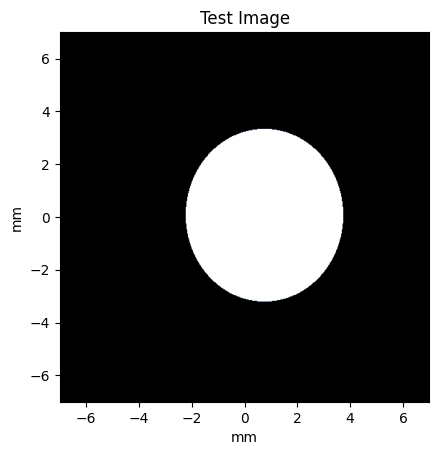

In [75]:
image = allmasks[0]
dim = image.shape[0]
half_dim = 7
axis_label = "mm"
extent = [(-half_dim), half_dim, (-half_dim), half_dim]
    
plt.imshow(image, cmap=plt.cm.bone, vmin=0, vmax=1, extent=extent)
plt.title("Test Image")
plt.xlabel(axis_label)
plt.ylabel(axis_label)
plt.show()

In [15]:
#!pip install scikit-learn

In [179]:
# already imported
# from sklearn.model_selection import train_test_split

#90% train, 10% test
X_train, X_test, y_train, y_test = train_test_split(allimages, allmasks, test_size=0.1, random_state=42)

#80% train, 10% test, 10% validation
one_ninth = 1/9
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=one_ninth, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print()


# save the data

# DENOTE ATTEMPT FOLDER! DO NOT OVERWRITE!
attempt_folder_str = 'attempt-zero/'


processed_data_folder_path = '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/'

print("Initiating process of saving Test-Train-Split data... ")
np.save(processed_data_folder_path+attempt_folder_str+'Unet-IVUS-images-X_train.npy', X_train)
print('saved \'/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/'+attempt_folder_str+'Unet-IVUS-images-X_train.npy\'')
np.save(processed_data_folder_path+attempt_folder_str+'Unet-IVUS-images-y_train.npy', y_train)
print('saved \'/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/'+attempt_folder_str+'Unet-IVUS-images-y_train.npy\'')
np.save(processed_data_folder_path+attempt_folder_str+'Unet-IVUS-images-X_val.npy', X_val)
print('saved \'/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/'+attempt_folder_str+'Unet-IVUS-images-X_val.npy\'')
np.save(processed_data_folder_path+attempt_folder_str+'Unet-IVUS-images-y_val.npy',y_val)
print('saved \'/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/'+attempt_folder_str+'/net-IVUS-images-y_val.npy\'')
np.save(processed_data_folder_path+attempt_folder_str+'Unet-IVUS-images-X_test.npy', X_test)
print('saved \'/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/'+attempt_folder_str+'Unet-IVUS-images-X_test.npy\'')
np.save(processed_data_folder_path+attempt_folder_str+'Unet-IVUS-images-y_test.npy', y_test)
print('saved \'/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/'+attempt_folder_str+'Unet-IVUS-images-y_test.npy\'')
print("Finished saving the data ...")


X_train shape: (33, 512, 512, 1)
y_train shape: (33, 512, 512)
X_test shape: (5, 512, 512, 1)
y_test shape: (5, 512, 512)
X_val shape: (5, 512, 512, 1)
y_val shape: (5, 512, 512)

Initiating process of saving Test-Train-Split data... 
saved '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/attempt-zero/Unet-IVUS-images-X_train.npy'
saved '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/attempt-zero/Unet-IVUS-images-y_train.npy'
saved '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/attempt-zero/Unet-IVUS-images-X_val.npy'
saved '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/attempt-zero//net-IVUS-images-y_val.npy'
saved '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/attempt-zero/Unet-IVUS-images-X_test.npy'
saved '/Users/brianmulhern/Documents/dev/arterial-stiffness/art-stiff/data/processed/attempt-zero/Unet-IVUS-images-y_test.npy'
Fin

In [17]:
#!pip install tensorflow

In [18]:
#import tensorflow as tf
#from tensorflow.keras.layers import *
#from tensorflow.keras.models import Model 